> # Imports

In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

%matplotlib inline

# TPU 

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMG_SIZE = 768

print('Batch size:', BATCH_SIZE)

Running on TPU: grpc://10.0.0.2:8470
Batch size: 64


# Data Reading and Processing

In [3]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

print(train.head())

train_path = train.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
test_path = test.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
train_label = train.loc[:, 'healthy':].values

train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label, test_size=0.1, stratify=train_label)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.1, stratify=train_label)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [4]:
print(f'test:{len(test_path)}')
print(f'train:{len(train_path)}')
print(f'valid:{len(valid_path)}')

test:164
train:1474
valid:183


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[0 1 3 ... 3 0 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<BarContainer object of 4 artists>

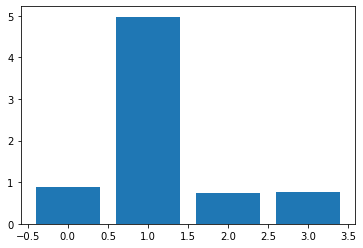

In [5]:
class_weight = compute_class_weight('balanced', np.unique(np.argmax(train_label, axis=1)), np.argmax(train_label, axis=1))
plt.bar(range(4), class_weight)

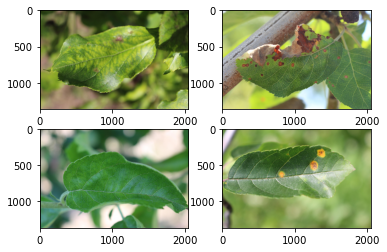

In [6]:
fig, ax = plt.subplots(2, 2)
img = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
img1 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1.jpg')
img2 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_2.jpg')
img3 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg')
ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0, 1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

In [7]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [8]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((train_path, train_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((valid_path, valid_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((test_path, test_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

# Parameters

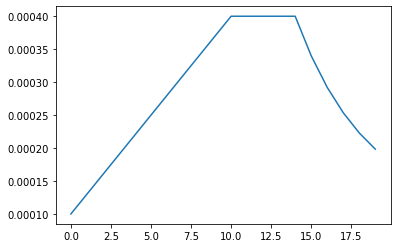

In [9]:
EPOCHS = 20
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn)

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

# Model

In [10]:
!pip install -q efficientnet

In [11]:
from efficientnet.tfkeras import EfficientNetB7

with strategy.scope():
    efn = EfficientNetB7(include_top=False, weights='noisy-student', pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(efn)
    model.add(L.Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
    print(model.summary())

258072576/258068648 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
None


# Train

In [12]:
mc = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True, save_weights_only=True)
history = model.fit(train_dataset, validation_data=valid_dataset,epochs=EPOCHS, callbacks=[lr, mc], steps_per_epoch=train_label.shape[0] // BATCH_SIZE)

Epoch 1/20
23/23 [==============================] - 300s 3s/step - loss: 1.2490 - accuracy: 0.4457 - true_negatives: 2375.8333 - true_positives: 57.3750 - false_negatives: 739.9583 - false_positives: 16.1667 - val_loss: 1.0048 - val_accuracy: 0.4208 - val_true_negatives: 547.0000 - val_true_positives: 60.0000 - val_false_negatives: 123.0000 - val_false_positives: 2.0000
Epoch 2/20
23/23 [==============================] - 26s 1s/step - loss: 0.6935 - accuracy: 0.7885 - true_negatives: 2315.2917 - true_positives: 543.1667 - false_negatives: 254.1667 - false_positives: 76.7083 - val_loss: 0.4927 - val_accuracy: 0.8251 - val_true_negatives: 530.0000 - val_true_positives: 137.0000 - val_false_negatives: 46.0000 - val_false_positives: 19.0000
Epoch 3/20
23/23 [==============================] - 25s 1s/step - loss: 0.4103 - accuracy: 0.8761 - true_negatives: 2315.7917 - true_positives: 682.6667 - false_negatives: 114.6667 - false_positives: 76.2083 - val_loss: 0.5296 - val_accuracy: 0.8306 - v

# Predict

In [13]:
with strategy.scope():
    model.load_weights('weights.h5')
test_prob = model.predict(test_dataset, verbose=1)
print(metrics.classification_report(np.argmax(test_label, axis=1), np.argmax(test_prob, axis=1))) #healthy, md, rust, scab
print(metrics.confusion_matrix(np.argmax(test_label, axis=1), np.argmax(test_prob, axis=1))) #https://en.wikipedia.org/wiki/Confusion_matrix

3/3 [==============================] - 35s 15s/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       0.80      0.50      0.62         8
           2       0.96      0.98      0.97        56
           3       0.98      0.98      0.98        53

    accuracy                           0.96       164
   macro avg       0.93      0.87      0.89       164
weighted avg       0.96      0.96      0.96       164

[[47  0  0  0]
 [ 1  4  2  1]
 [ 1  0 55  0]
 [ 0  1  0 52]]


In [14]:
score = model.evaluate(test_dataset, verbose=False) 
model.metrics_names
print('Test loss: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

Test loss:  0.19745905697345734
Test accuracy:  0.9634146094322205


In [15]:
#probs = model.predict(test_dataset, verbose=1)
#sub.loc[:, 'healthy':] = probs
#sub.to_csv('submission.csv', index=False)
#sub.head()